In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})
pd.options.mode.chained_assignment = None  # default='warn'

In [50]:
#load data for researchers and divisions
df_researchers = pd.read_pickle("Files/Dataframes/researchersFinal.pkl") 
researchers = df_researchers.drop_duplicates(subset = ['API_Name', 'Year', 'SessionType']) #only unique researchers(wrt. year and session type)
divisionResearchers = df_researchers.drop_duplicates(subset = ['API_Name', 'Year', 'AllDivisions', 'SessionType']) #unique researchers, also wrt. division

In [51]:
researchers['log_MaxPaperCount'] = np.log2(researchers.MaxPaperCount)
researchers['log_CumulativePaperCount'] = np.log2(researchers.CumulativePaperCount)
researchers['log_Productivity'] = np.log2(researchers.Productivity)
researchers['log_AuthorCount'] = np.log2(researchers.AuthorCount)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


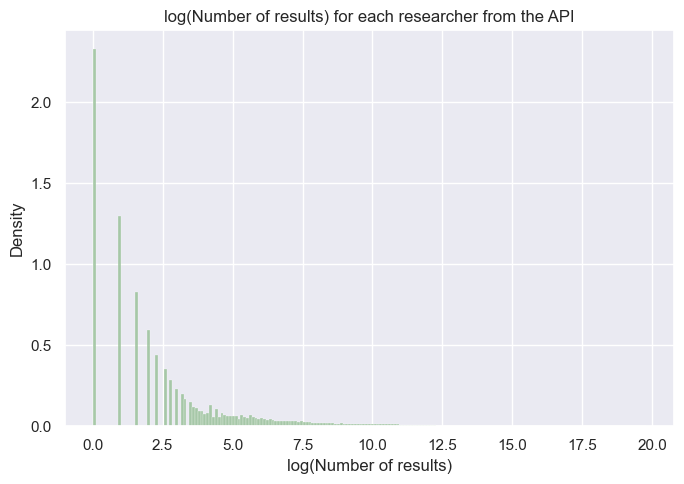

In [52]:
sns.histplot(data = researchers, x = 'log_AuthorCount', stat = 'density', color = 'darkseagreen')
plt.xlabel('log(Number of results)')
plt.title('log(Number of results) for each researcher from the API')
plt.tight_layout()
plt.savefig("Figures/authorCount.png", bbox_inches='tight')
plt.show()

In [53]:
fields = (researchers.groupby('Field').count()/len(researchers)).sort_values(by ='ID', ascending = False).reset_index()

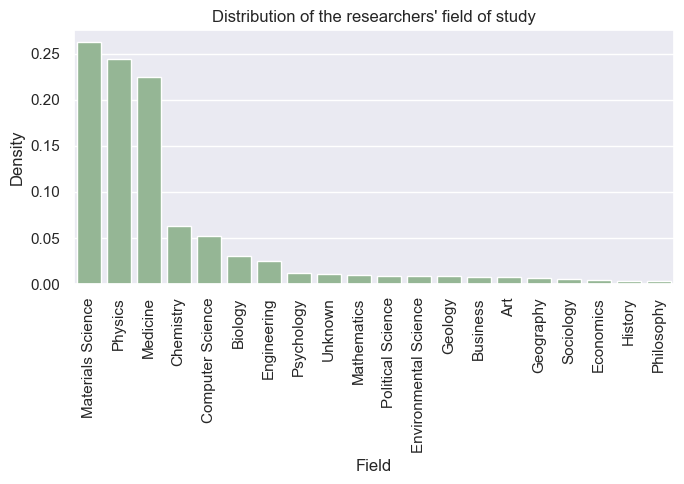

In [54]:
sns.barplot(data = fields, x = 'Field', y = 'ID', color = 'darkseagreen')
plt.xticks(rotation=90)
plt.xlabel('Field')
plt.ylabel('Density')
plt.title("Distribution of the researchers' field of study")
plt.tight_layout()
plt.savefig("Figures/fieldPlot.png", bbox_inches='tight')
plt.show()

### Researchers within medicine

In [55]:
medicineResearchers = researchers[researchers.Field == 'Medicine'].reset_index()
print("Share of attendees with medicine as field:", medicineResearchers.groupby('SessionType').count()['ID']['attendee']/len(researchers[researchers.SessionType == 'attendee']))
print("Share of invited speakers with medicine as field:", medicineResearchers.groupby('SessionType').count()['ID']['invited']/len(researchers[researchers.SessionType == 'invited']))

Share of attendees with medicine as field: 0.224229994991069
Share of invited speakers with medicine as field: 0.2243974512882076


In [56]:
#medicineResearchers[medicineResearchers.]
medicineResearchers_count = medicineResearchers.groupby('AuthorIndex').count().reset_index()

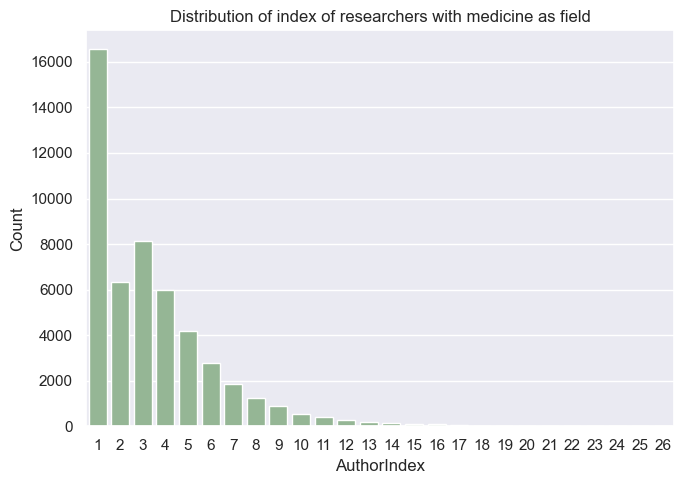

In [123]:
sns.barplot(data = medicineResearchers_count, x = 'AuthorIndex', y = 'ID', color = 'darkseagreen')
plt.ylabel('Count')
plt.title("Distribution of index of researchers with medicine as field")
plt.tight_layout()
plt.savefig("Figures/researcherIndex_medicine.png", bbox_inches='tight')
plt.show()

In [60]:
medicineResearchers['PercentWithinField'] = medicineResearchers['FieldCount']/medicineResearchers['MaxPaperCount']

In [62]:
medicineResearchers_fieldCount = medicineResearchers.groupby('FieldCount').count().reset_index()

In [135]:
medicineResearchers[medicineResearchers.FieldCount == 487]

,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,FieldCount,...,Seniority,CumulativePaperCount,Productivity,Gender,AllDivisions,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PercentWithinField
18963,168681,192508,120957,p. schuetz,P. Schuetz,Tobias,32,500,Medicine,487,...,6,104,17.333333,M,DCMP,8.965784,6.70044,4.115477,5.0,0.974


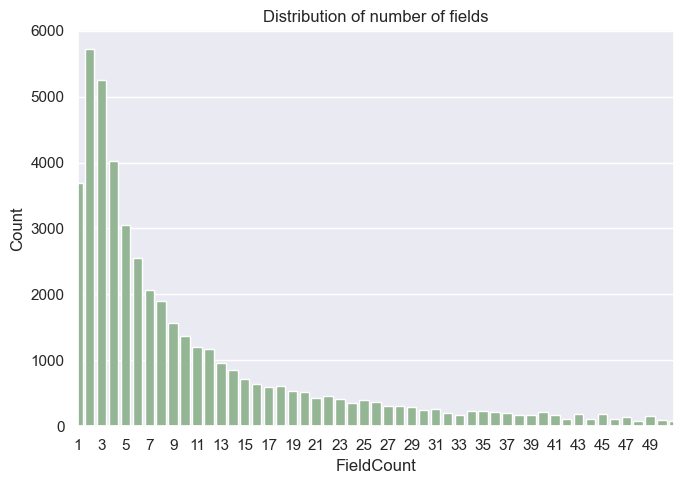

In [136]:
sns.barplot(data = medicineResearchers_fieldCount, x = 'FieldCount', y = 'ID', color = 'darkseagreen')
plt.xlim(0,50)
plt.xticks(np.arange(0,50, 2)) 
#plt.xlabel('Researcher index')
plt.ylabel('Count')
plt.title("Distribution of number of fields")
plt.tight_layout()
plt.savefig("Figures/fieldCount_medicine.png", bbox_inches='tight')
plt.show()

In [86]:
percentField_medicine

,PercentWithinField,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,...,LowerCaseName,Seniority,CumulativePaperCount,Productivity,Gender,AllDivisions,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount
0,1.000000,8237,8237,8237,8237,8237,8237,8237,8237,8237,...,8237,8237,8237,7990,8237,8237,8237,8237,7990,8237
1,0.992288,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0.991453,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0.990476,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,0.989744,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,0.061224,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2003,0.038462,18,18,18,18,18,18,18,18,18,...,18,18,18,17,18,18,18,18,17,18
2004,0.037037,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2005,0.031746,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [144]:
medicineResearchers[medicineResearchers.PercentWithinField >= 0.7]

,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,FieldCount,...,Seniority,CumulativePaperCount,Productivity,Gender,AllDivisions,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PercentWithinField
0,25,26,155033,c. shin,C. Shin,Xuefen,1004,42,Medicine,37,...,18,28,1.555556,F,DMP,5.392317,4.807355,0.637430,9.971544,0.880952
2,32,33,155040,weihua liu,Wei-Hsiu Liu,Uli,124,4,Medicine,3,...,7,4,0.571429,F,GMAG,2.000000,2.000000,-0.807355,6.954196,0.75
3,33,34,155040,weihua liu,Wei-Hsiu Liu,Uli,124,4,Medicine,3,...,8,4,0.500000,F,DMP,2.000000,2.000000,-1.000000,6.954196,0.75
4,53,59,155063,b. kimball,B. Kimball,T.,90,20,Medicine,19,...,26,19,0.730769,M,DCMP,4.321928,4.247928,-0.452512,6.491853,0.95
5,54,60,155063,b. kimball,B. Kimball,T.,90,20,Medicine,19,...,25,19,0.760000,M,DCMP,4.321928,4.247928,-0.395929,6.491853,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49876,463142,527939,35979,lauren cooper,L. Cooper,Malliga,36,26,Medicine,26,...,-5,0,-0.000000,F,DMP,4.700440,-inf,-inf,5.169925,1.0
49877,463144,527941,35979,lauren cooper,L. Cooper,Malliga,36,26,Medicine,26,...,6,10,1.666667,F,GMAG,4.700440,3.321928,0.736966,5.169925,1.0
49878,463145,527942,35979,lauren cooper,L. Cooper,Malliga,36,26,Medicine,26,...,-6,0,-0.000000,F,DMP,4.700440,-inf,-inf,5.169925,1.0
49879,463154,527951,35983,stefan vuckovic,Stefan Vuckovic,Bernhard,1,36,Medicine,26,...,-1,0,-0.000000,M,GSNP,5.169925,-inf,-inf,0.000000,0.722222


In [145]:
24353/len(medicineResearchers)

0.48821218074656186

In [146]:
percentField_medicine = medicineResearchers.groupby('PercentWithinField').count().sort_values(by ='PercentWithinField', ascending = False).reset_index()
percentField_medicine
#.iloc[0:20]

,PercentWithinField,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,...,LowerCaseName,Seniority,CumulativePaperCount,Productivity,Gender,AllDivisions,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount
0,1.000000,8237,8237,8237,8237,8237,8237,8237,8237,8237,...,8237,8237,8237,7990,8237,8237,8237,8237,7990,8237
1,0.992288,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0.991453,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0.990476,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,0.989744,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,0.061224,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2003,0.038462,18,18,18,18,18,18,18,18,18,...,18,18,18,17,18,18,18,18,17,18
2004,0.037037,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2005,0.031746,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [156]:
medicineResearchers.groupby(pd.cut(medicineResearchers["PercentWithinField"], np.arange(0, 1.0, 0.1))).count()

,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,FieldCount,...,Seniority,CumulativePaperCount,Productivity,Gender,AllDivisions,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PercentWithinField
PercentWithinField,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0.1]",79,79,79,79,79,79,79,79,79,79,...,79,79,76,79,79,79,79,76,79,79
"(0.1, 0.2]",1014,1014,1014,1014,1014,1014,1014,1014,1014,1014,...,1014,1014,975,1014,1014,1014,1014,975,1014,1014
"(0.2, 0.3]",1717,1717,1717,1717,1717,1717,1717,1717,1717,1717,...,1717,1717,1664,1717,1717,1717,1717,1664,1717,1717
"(0.3, 0.4]",4034,4034,4034,4034,4034,4034,4034,4034,4034,4034,...,4034,4034,3901,4034,4034,4034,4034,3901,4034,4034
"(0.4, 0.5]",7348,7348,7348,7348,7348,7348,7348,7348,7348,7348,...,7348,7348,7081,7348,7348,7348,7348,7081,7348,7348
"(0.5, 0.6]",5102,5102,5102,5102,5102,5102,5102,5102,5102,5102,...,5102,5102,4929,5102,5102,5102,5102,4929,5102,5102
"(0.6, 0.7]",6466,6466,6466,6466,6466,6466,6466,6466,6466,6466,...,6466,6466,6259,6466,6466,6466,6466,6259,6466,6466
"(0.7, 0.8]",6934,6934,6934,6934,6934,6934,6934,6934,6934,6934,...,6934,6934,6702,6934,6934,6934,6934,6702,6934,6934
"(0.8, 0.9]",5493,5493,5493,5493,5493,5493,5493,5493,5493,5493,...,5493,5493,5355,5493,5493,5493,5493,5355,5493,5493


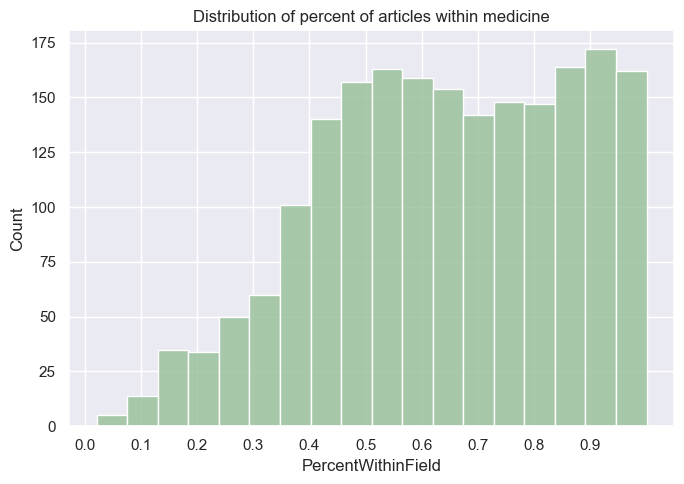

In [165]:
sns.histplot(data = percentField_medicine, x = 'PercentWithinField', color = 'darkseagreen')
plt.xticks(np.arange(0, 1, 0.1)) 
#plt.xlabel('Researcher index')
#plt.ylabel('Count')
plt.title("Distribution of percent of articles within medicine")
plt.tight_layout()
plt.savefig("Figures/percentField_medicine.png", bbox_inches='tight')
plt.show()

In [166]:
medicineResearchers.groupby('AllDivisions').count().sort_values(by = 'ID', ascending = False)

,level_0,index,ID,SearchName,API_Name,FirstName,AuthorCount,MaxPaperCount,Field,FieldCount,...,LowerCaseName,Seniority,CumulativePaperCount,Productivity,Gender,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PercentWithinField
AllDivisions,,,,,,,,,,,,,,,,,,,,,
DMP,11323,11323,11323,11323,11323,11323,11323,11323,11323,11323,...,11323,11323,11323,10936,11323,11323,11323,10936,11323,11323
DCMP,9815,9815,9815,9815,9815,9815,9815,9815,9815,9815,...,9815,9815,9815,9506,9815,9815,9815,9506,9815,9815
GMAG,5308,5308,5308,5308,5308,5308,5308,5308,5308,5308,...,5308,5308,5308,5131,5308,5308,5308,5131,5308,5308
DPOLY,4219,4219,4219,4219,4219,4219,4219,4219,4219,4219,...,4219,4219,4219,4088,4219,4219,4219,4088,4219,4219
DBIO,2782,2782,2782,2782,2782,2782,2782,2782,2782,2782,...,2782,2782,2782,2716,2782,2782,2782,2716,2782,2782
DQI,2600,2600,2600,2600,2600,2600,2600,2600,2600,2600,...,2600,2600,2600,2531,2600,2600,2600,2531,2600,2600
DCOMP,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523,...,2523,2523,2523,2446,2523,2523,2523,2446,2523,2523
GSNP,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011,...,2011,2011,2011,1939,2011,2011,2011,1939,2011,2011
FIAP,1947,1947,1947,1947,1947,1947,1947,1947,1947,1947,...,1947,1947,1947,1883,1947,1947,1947,1883,1947,1947


In [167]:
#check what is happening with medicine

In [168]:
invited = researchers[researchers.SessionType == 'invited']
attendees = researchers[researchers.SessionType == 'attendee'] #change this to == 'participant'

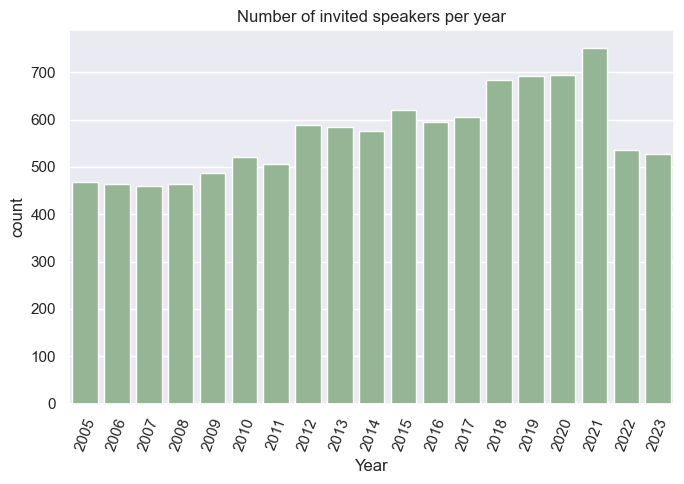

In [169]:
sns.countplot(x = 'Year', data = invited , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.title('Number of invited speakers per year')
plt.tight_layout()
plt.savefig("Figures/invitedSpeakers.png", bbox_inches='tight')
plt.show()

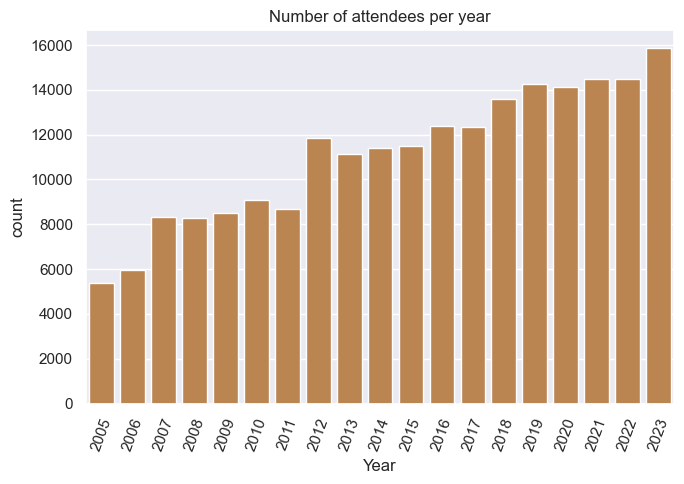

In [170]:
sns.countplot(x = 'Year', data = attendees , color = 'peru')
plt.xticks(rotation=70)
plt.title('Number of attendees per year')
plt.tight_layout()
plt.savefig("Figures/participants.png", bbox_inches='tight')
plt.show()

In [171]:
invited_divisions = divisionResearchers[divisionResearchers.SessionType == 'invited']
attendees_divisions = divisionResearchers[divisionResearchers.SessionType == 'attendee']

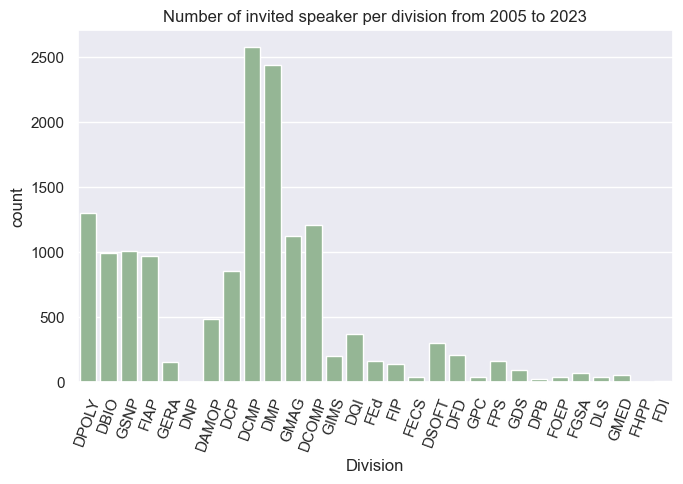

In [172]:
sns.countplot(x = 'AllDivisions', data = invited_divisions , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.xlabel('Division')
plt.title('Number of invited speaker per division from 2005 to 2023')
plt.tight_layout()
plt.savefig("Figures/invited_divisions.png", bbox_inches='tight')
plt.show()

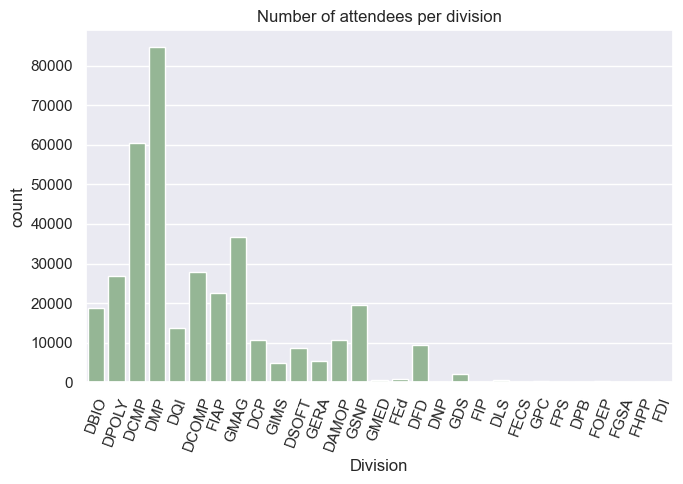

In [173]:
sns.countplot(x = 'AllDivisions', data = attendees_divisions , color = 'darkseagreen')
plt.xticks(rotation=70)
plt.xlabel('Division')
plt.title('Number of attendees per division')
plt.tight_layout()
plt.savefig("Figures/participants_divisions.png", bbox_inches='tight')
plt.show()

In [174]:
#calculate gender ratio
genderRatio_invited = pd.crosstab(index=invited.Year,
                             columns=invited.Gender,
                             normalize="index").rename(columns = {'F': 'Female invited', 'M': 'Male invited'})

genderRatio_attendees = pd.crosstab(index=attendees.Year,
                             columns=attendees.Gender,
                             normalize="index").rename(columns = {'F': 'Female attendees', 'M': 'Male attendees'})

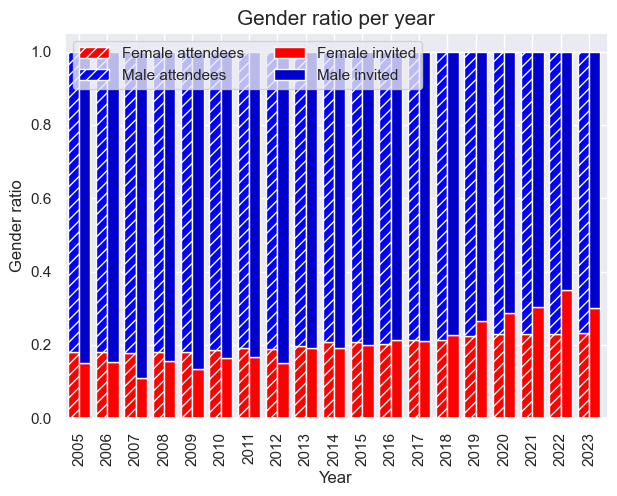

In [175]:
fig, ax = plt.subplots()
genderRatio_attendees.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['red', 'blue'], hatch = '///')
genderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"])
#ax.set_xlim(right=len(genderRatio_invited)-0.5)
ax.set_xlim(left=-0.5)
#ax.set_edgecolor(color = 'black')
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per year", fontsize = 15)
plt.xlabel("Year")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio.png", bbox_inches='tight')
plt.show()

In [176]:
divGenderRatio_invited = pd.crosstab(index=invited_divisions.AllDivisions,
                             columns=invited_divisions.Gender,
                             normalize="index").rename(columns = {'F': 'Female invited', 'M': 'Male invited'})

divGenderRatio_participants = pd.crosstab(index=attendees_divisions.AllDivisions,
                             columns=attendees_divisions.Gender,
                             normalize="index").rename(columns = {'F': 'Female attendees', 'M': 'Male attendees'})

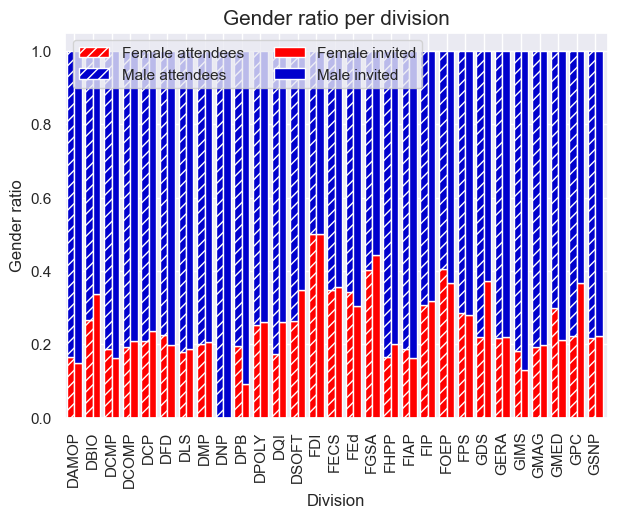

In [177]:
fig, ax = plt.subplots()
divGenderRatio_participants.plot(kind='bar', stacked=True, width = 0.4, position = 1, ax = ax, color = ['red', 'mediumblue'], hatch = '///')
divGenderRatio_invited.plot(kind='bar', stacked=True, width = 0.4, position=0, ax = ax, color = ['red', "mediumblue"])
ax.set_xlim(left=-0.5)
plt.legend(loc="upper left", ncol = 2)
plt.title("Gender ratio per division", fontsize = 15)
plt.xlabel("Division")
plt.ylabel("Gender ratio")
plt.savefig("Figures/genderRatio_Divisions.png", bbox_inches='tight')
plt.show()

In [178]:
invitedSpeakers_genderCount = invited.groupby(['Year', 'Gender']).count().reset_index()
participants_genderCount = attendees.groupby(['Year', 'Gender']).count().reset_index()

In [179]:
#get lineplot to show int as in data and not 
years = invitedSpeakers_genderCount.Year.unique().tolist()

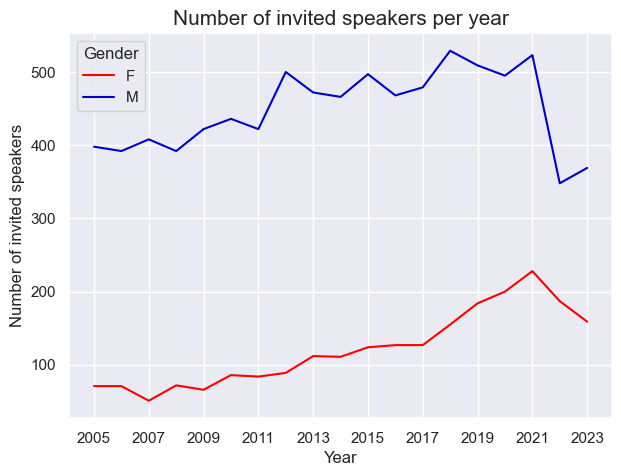

In [180]:
sns.lineplot(data = invitedSpeakers_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=['red', 'mediumblue'])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of invited speakers", fontsize=12)
plt.title("Number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/nInvitedSpeakers.png", bbox_inches='tight')
plt.show()

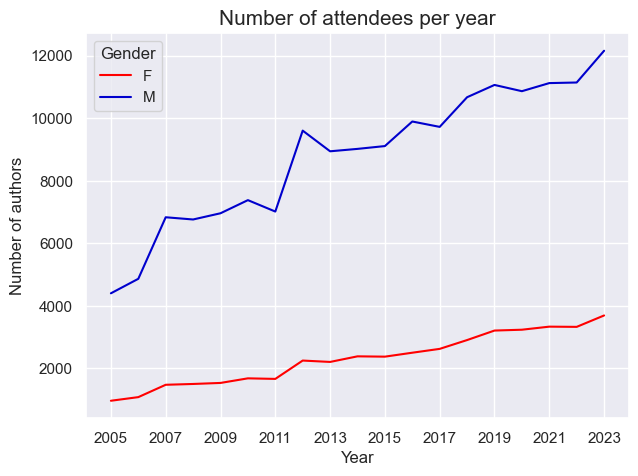

In [181]:
sns.lineplot(data = participants_genderCount, x = 'Year', y = 'Name', hue = 'Gender',  palette=["red", "mediumblue"])
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of authors", fontsize=12)
plt.title("Number of attendees per year", fontsize = 15)
plt.savefig("Figures/nParticipants.png", bbox_inches='tight')
plt.show()

In [182]:
#calculate percentage increase
invitedSpeakers_genderCount_F = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'F']
invitedSpeakers_genderCount_M = invitedSpeakers_genderCount[invitedSpeakers_genderCount.Gender == 'M']
participants_genderCount_F = participants_genderCount[participants_genderCount.Gender == 'F']
participants_genderCount_M = participants_genderCount[participants_genderCount.Gender == 'M']

#calculate and add the increase
invitedSpeakers_genderCount_F['Increase'] = invitedSpeakers_genderCount_F.ID.pct_change().fillna(0) * 100
invitedSpeakers_genderCount_M['Increase'] = invitedSpeakers_genderCount_M.ID.pct_change().fillna(0) * 100
participants_genderCount_F['Increase'] = participants_genderCount_F.ID.pct_change().fillna(0) * 100
participants_genderCount_M['Increase'] = participants_genderCount_M.ID.pct_change().fillna(0) * 100

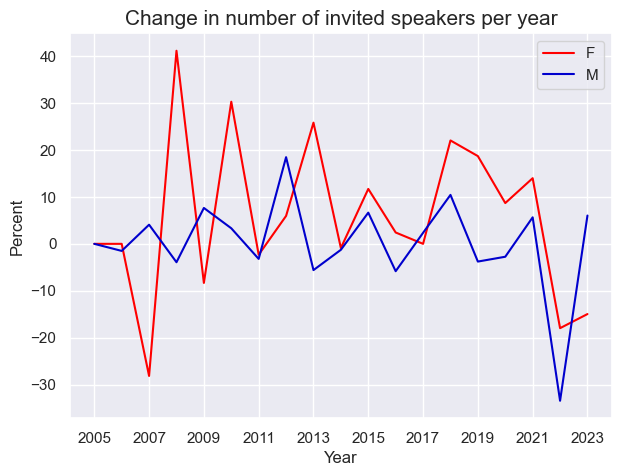

In [183]:
sns.lineplot(data = invitedSpeakers_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'F')
sns.lineplot(data = invitedSpeakers_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'M')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of invited speakers per year", fontsize = 15)
plt.savefig("Figures/invited_change.png", bbox_inches='tight')
plt.show()

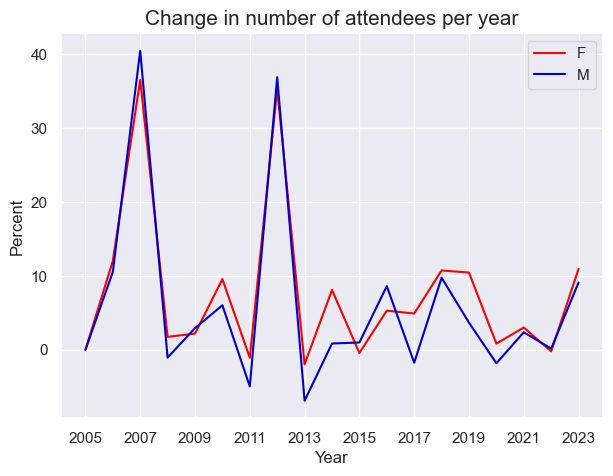

In [184]:
sns.lineplot(data = participants_genderCount_F, x = 'Year', y = 'Increase', color = 'red', label = 'F')
sns.lineplot(data = participants_genderCount_M, x = 'Year', y = 'Increase', color = 'mediumblue', label = 'M')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.ylabel("Percent", fontsize=12)
plt.title("Change in number of attendees per year", fontsize = 15)
plt.savefig("Figures/attendees_change.png", bbox_inches='tight')
plt.show()

In [185]:
invDiv_gender = invited[invited.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()
attDiv_gender = attendees[attendees.Division == 'FOEP'].groupby(['Year', 'Gender']).count().reset_index()

In [186]:
#change over time with FDI
print("Largest:", divGenderRatio_invited['Female invited'].nlargest(n=2))
print("Smallest:", divGenderRatio_invited['Female invited'].nsmallest(n=3))
#FDI, FGSA, DPB, FHPP, FOEP

#FDI: only one, so not worth looking at
#FGSA: too few
#DPB: too few
#FHPP: too few

#find someone else with many females, with more data

Largest: AllDivisions
FDI     0.500000
FGSA    0.442857
Name: Female invited, dtype: float64
Smallest: AllDivisions
DNP     0.000000
DPB     0.090909
GIMS    0.130000
Name: Female invited, dtype: float64


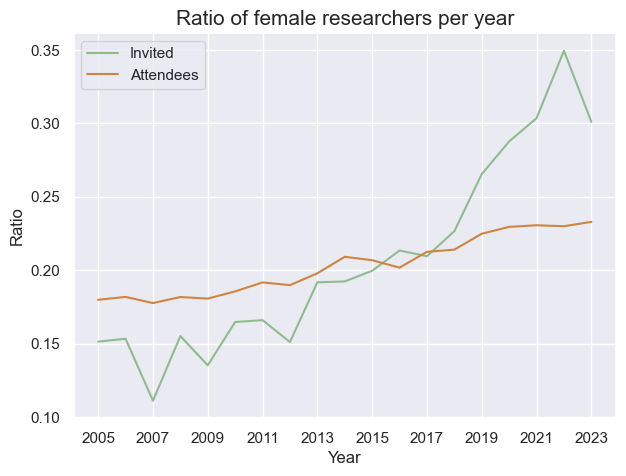

In [187]:
sns.lineplot(data = genderRatio_invited.reset_index(), x = 'Year', y = 'Female invited', color = 'darkseagreen', label = 'Invited')
sns.lineplot(data = genderRatio_attendees.reset_index(), x = 'Year', y = 'Female attendees', color = 'peru', label = 'Attendees')
plt.xticks(np.arange(min(years), max(years)+1, 2.0))
plt.xlabel("Year", fontsize=12)
plt.ylabel("Ratio", fontsize=12)
plt.title("Ratio of female researchers per year", fontsize = 15)
plt.savefig("Figures/FemaleRatio.png", bbox_inches='tight')
plt.show()

In [188]:
#show ratio of some specific fields

### Publications

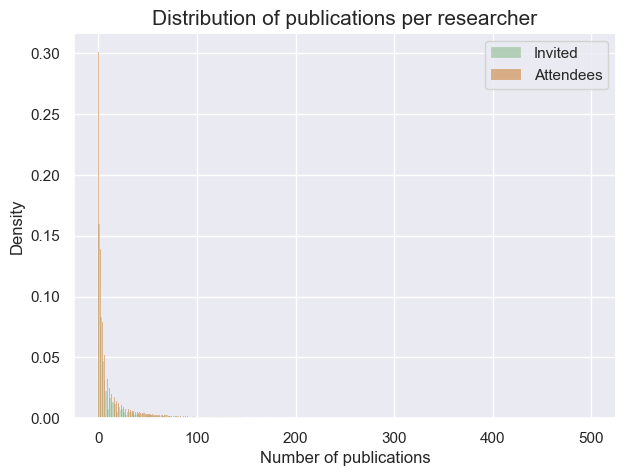

In [189]:
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'density', color = 'darkseagreen', label = 'Invited', alpha = 0.6)
sns.histplot(data = attendees, x = 'CumulativePaperCount', stat = 'density', color = 'peru', label = 'Attendees', alpha = 0.6)
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.savefig("Figures/publications_dist_all.png", bbox_inches='tight')
plt.show()

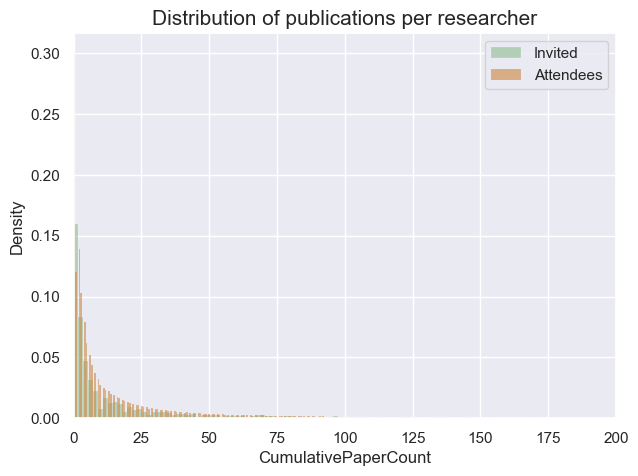

In [190]:
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'density', color = 'darkseagreen', label = 'Invited', alpha = 0.6)
sns.histplot(data = attendees, x = 'CumulativePaperCount', stat = 'density', color = 'peru', label = 'Attendees', alpha = 0.6)
plt.legend()
plt.xlim(0, 200)
plt.title("Distribution of publications per researcher", fontsize = 15)
plt.show()

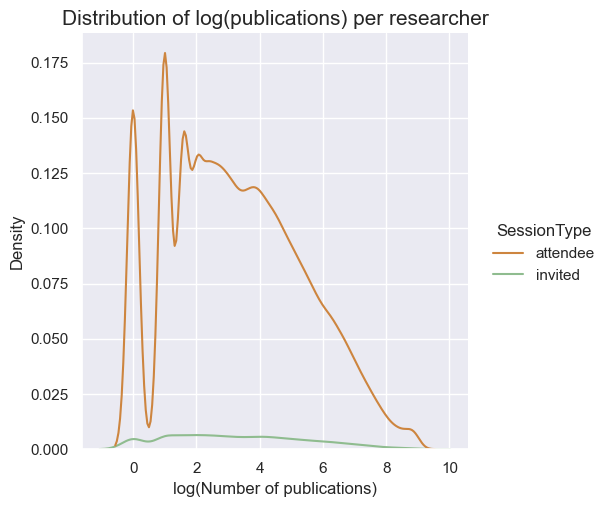

In [191]:
sns.displot(researchers, x = 'log_CumulativePaperCount', kind = 'kde', hue = 'SessionType', palette = ['peru', 'darkseagreen'])
plt.xlabel("log(Number of publications)", fontsize=12)
plt.title("Distribution of log(publications) per researcher", fontsize = 15)
plt.savefig("Figures/logPublications_dist_all.png", bbox_inches='tight')
plt.show()

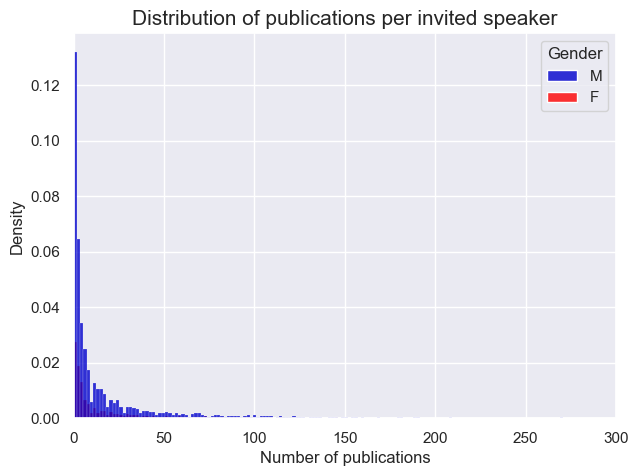

In [192]:
#something weird with these distributions. 
#Is it because it is calculated based on different things. Maybe it hould be as one. 
#hist of max papercount
sns.histplot(data = invited, x = 'CumulativePaperCount', hue = 'Gender', stat = 'density', palette=["mediumblue", "red"], alpha = 0.8)
plt.xlim(0, 300)
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per invited speaker", fontsize = 15)
plt.savefig("Figures/publications_dist_invited.png", bbox_inches='tight')
plt.show()

In [193]:
maleInv = invited[invited.Gender == 'M']
femaleInv = invited[invited.Gender == 'F']
maleAtt = attendees[attendees.Gender == 'M']
femaleAtt = attendees[attendees.Gender == 'F']

(0.0, 60.0)

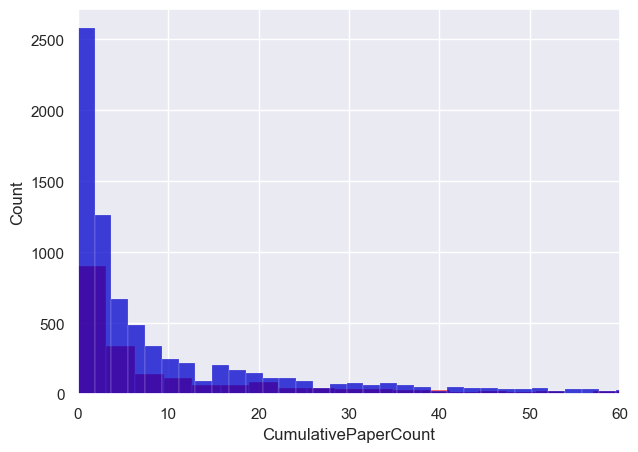

In [198]:
#same plot as the one above
sns.histplot(data = femaleInv, x = 'CumulativePaperCount', color = 'red', label = 'F')
sns.histplot(data = maleInv, x = 'CumulativePaperCount', color = 'mediumblue', label = 'M')
plt.xlim(0, 60)
#plt.legend()
#plt.xlabel("Number of publications", fontsize=12)
#plt.title("Distribution of publications per invited speaker", fontsize = 15)
#plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


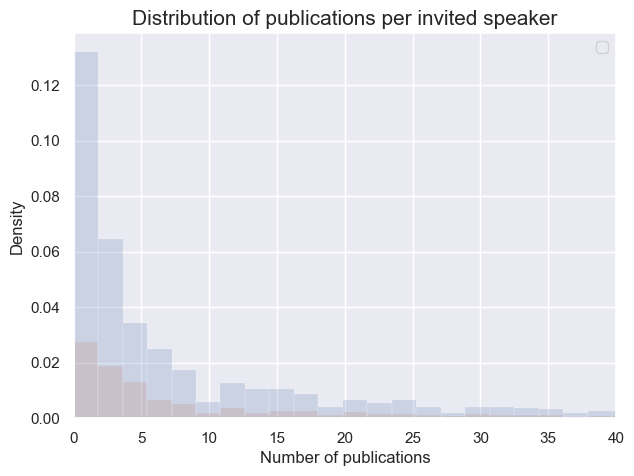

In [206]:
#same plot as the one above
sns.histplot(data = invited, x = 'CumulativePaperCount', stat = 'density', color = ['red', 'blue'], hue = 'Gender', alpha = 0.2)
#sns.histplot(data = maleInv, x = 'CumulativePaperCount', stat = 'density', color = 'mediumblue', label = 'M')
plt.xlim(0, 40)
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per invited speaker", fontsize = 15)
plt.show()

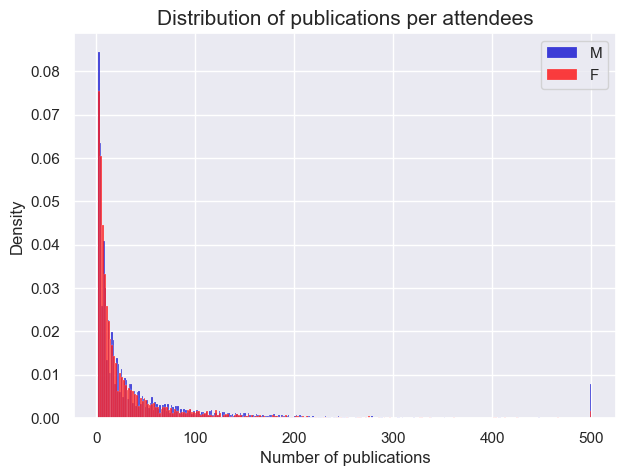

In [54]:
sns.histplot(data = maleAtt, x = 'MaxPaperCount', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleAtt, x = 'MaxPaperCount', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlabel("Number of publications", fontsize=12)
plt.title("Distribution of publications per attendees", fontsize = 15)
plt.savefig("Figures/publications_dist_attendees.png", bbox_inches='tight')
plt.show()

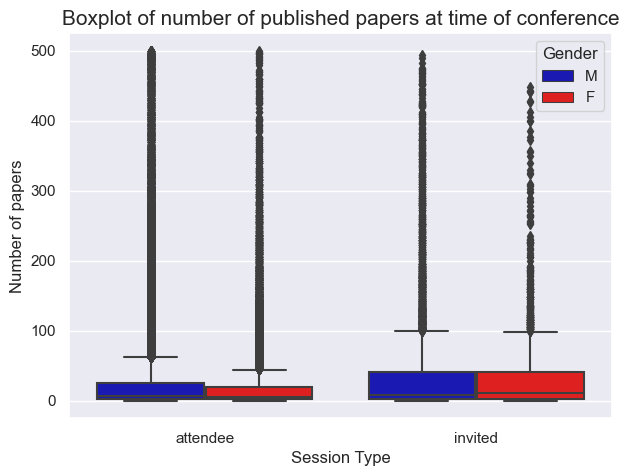

In [55]:
#boxplot of maxPaperCount
sns.boxplot(data=researchers, x="SessionType", y="CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Number of papers", fontsize=12)
plt.title("Boxplot of number of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

In [56]:
#should plot below be cut off at y for negative values?

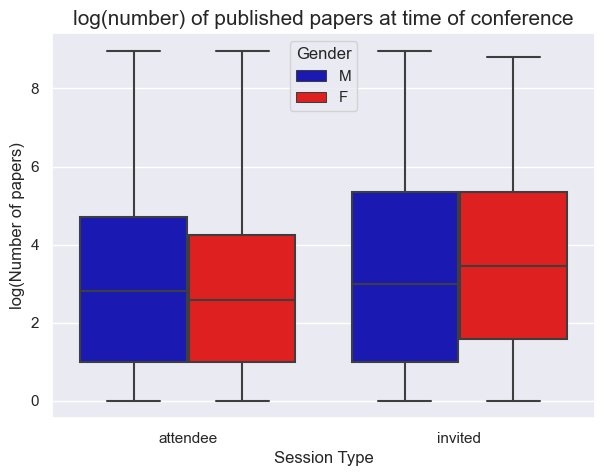

In [58]:
#boxplot of maxPaperCount
sns.boxplot(data=researchers, x="SessionType", y="log_CumulativePaperCount", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("log(number) of published papers at time of conference", fontsize = 15)
plt.savefig("Figures/maxPaperCount_boxplot", bbox_inches='tight')
plt.show()

#not #not containing researchers not publishing anything

In [59]:
bins = np.arange(0, 35, 5).tolist()
bins.append(float("inf"))
labels = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '> 30']

In [60]:
#create seniority categories
researchers['Seniority_cat'] = pd.cut(researchers['Seniority'], bins = bins, labels = labels)

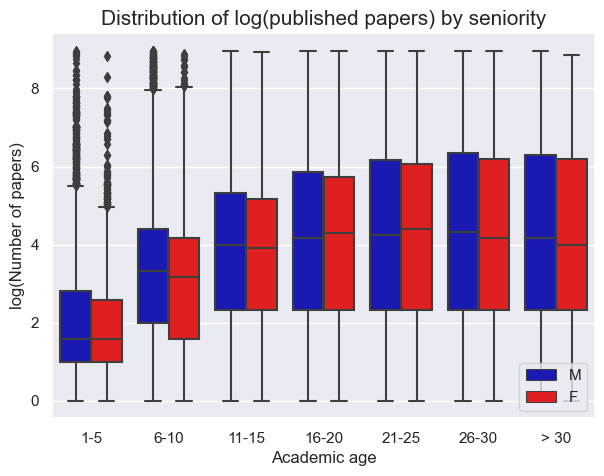

In [67]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_CumulativePaperCount', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Number of papers)", fontsize=12)
plt.title("Distribution of log(published papers) by seniority", fontsize = 15)
plt.legend(loc="lower right")
plt.savefig("Figures/paperCount_Seniority_boxplot", bbox_inches='tight')
plt.show()

In [43]:
### distribution(by histogram) of publications for invited speakers(male and female and female indicated) for a few divisions

### Seniority

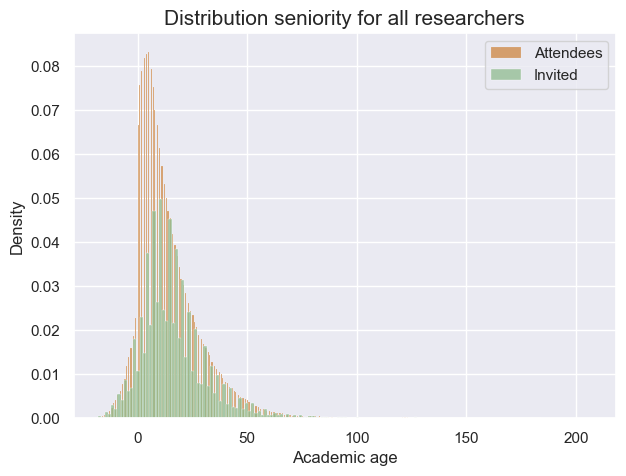

In [68]:
#distribution of seniority
sns.histplot(data = attendees, x = 'Seniority', stat = 'density', color = 'peru', label = 'Attendees')
sns.histplot(data = invited, x = 'Seniority', stat = 'density', color = 'darkseagreen', label = 'Invited')
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for all researchers", fontsize = 15)
plt.savefig("Figures/seniorityDist_all.png", bbox_inches='tight')
plt.show()

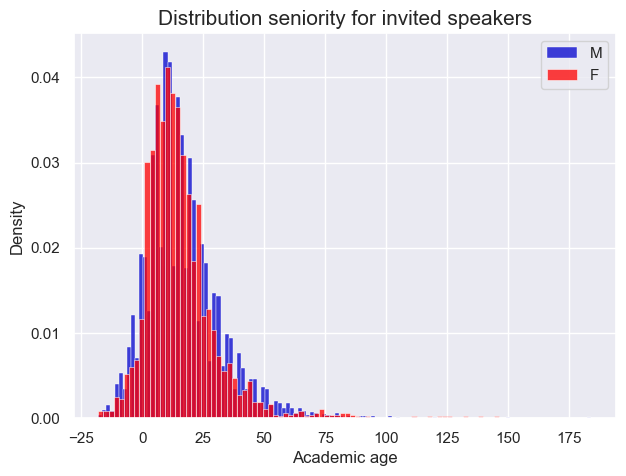

In [69]:
sns.histplot(data = maleInv , x = 'Seniority', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleInv, x = 'Seniority', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for invited speakers", fontsize = 15)
plt.savefig("Figures/seniorityDist_Invited.png", bbox_inches='tight')
plt.show()

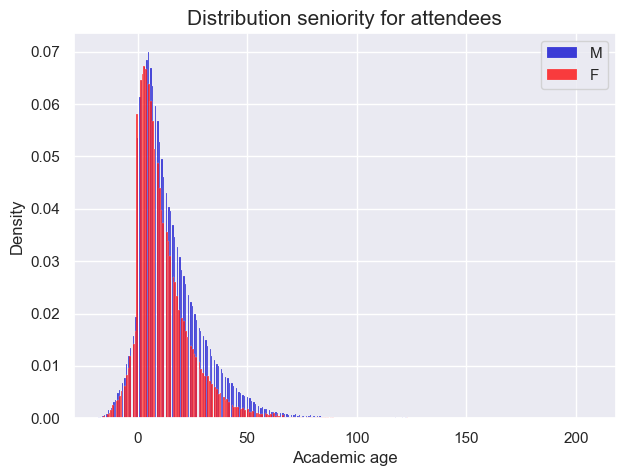

In [70]:
sns.histplot(data = maleAtt , x = 'Seniority', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleAtt, x = 'Seniority', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlabel("Academic age", fontsize=12)
plt.title("Distribution seniority for attendees", fontsize = 15)
plt.savefig("Figures/seniorityDist_Attendees.png", bbox_inches='tight')
plt.show()

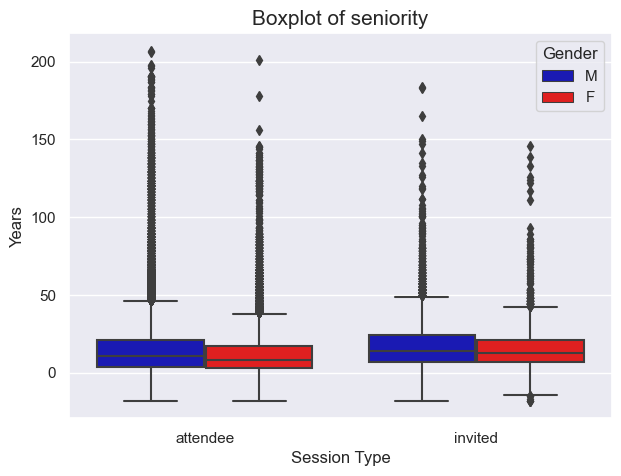

In [71]:
#boxplot of seniority
sns.boxplot(data=researchers , x="SessionType", y="Seniority", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Years", fontsize=12)
plt.title("Boxplot of seniority", fontsize = 15)
plt.savefig("Figures/seniority_boxplot", bbox_inches='tight')
plt.show()

### Productivity

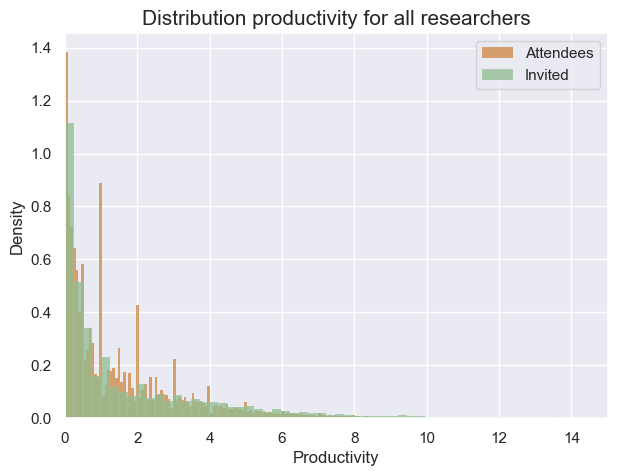

In [75]:
sns.histplot(data = attendees, x = 'Productivity', stat = 'density', color = 'peru', label = 'Attendees')
sns.histplot(data = invited, x = 'Productivity', stat = 'density', color = 'darkseagreen', label = 'Invited')
plt.legend()
plt.xlim(0, 15)
plt.title("Distribution productivity for all researchers", fontsize = 15)
plt.savefig("Figures/productivityDist_all.png", bbox_inches='tight')
plt.show()

#invited: darkseagreen
#attendees: peru

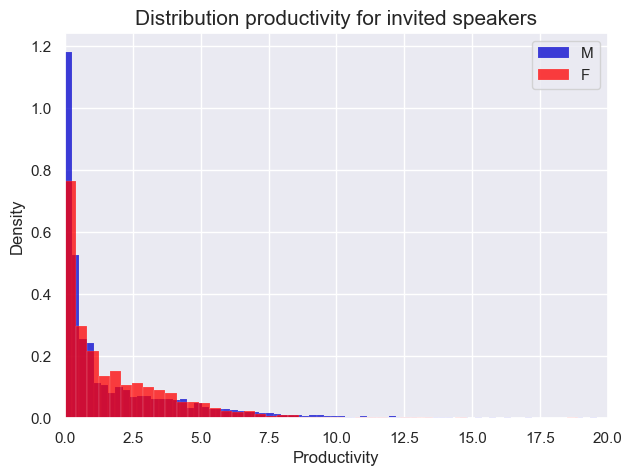

In [81]:
sns.histplot(data = maleInv , x = 'Productivity', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleInv, x = 'Productivity', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlim(0,20)
plt.title("Distribution productivity for invited speakers", fontsize = 15)
plt.savefig("Figures/productivityDist_Invited.png", bbox_inches='tight')
plt.show()

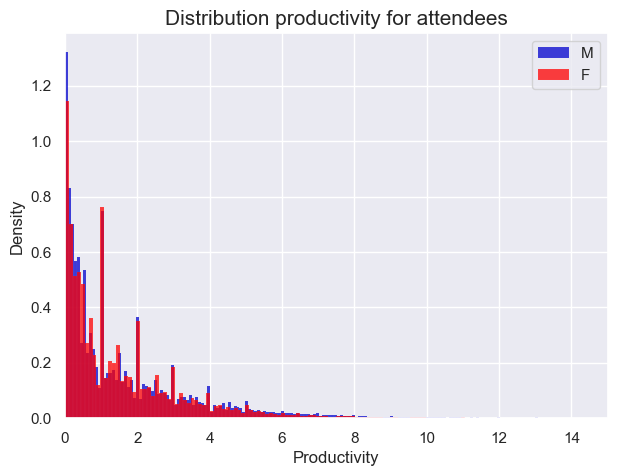

In [82]:
sns.histplot(data = maleAtt , x = 'Productivity', stat = 'density', color = 'mediumblue', label = 'M')
sns.histplot(data = femaleAtt, x = 'Productivity', stat = 'density', color = 'red', label = 'F')
plt.legend()
plt.xlim(0,15)
plt.title("Distribution productivity for attendees", fontsize = 15)
plt.savefig("Figures/productivityDist_Attendees.png", bbox_inches='tight')
plt.show()

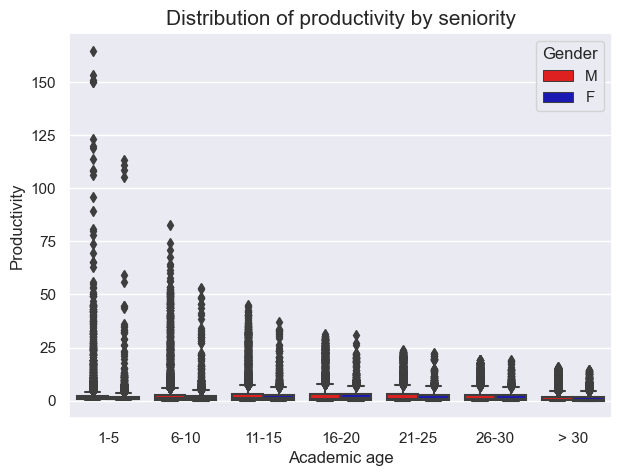

In [83]:
sns.boxplot(data=researchers , x="Seniority_cat", y='Productivity', hue='Gender', palette = ['red', 'mediumblue'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Distribution of productivity by seniority", fontsize = 15)
plt.savefig("Figures/productivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

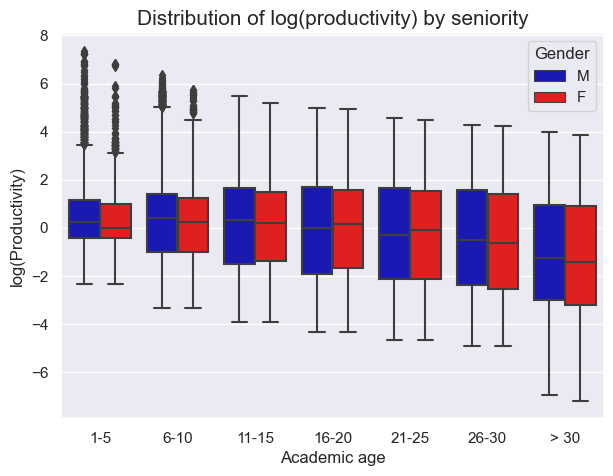

In [110]:
sns.boxplot(data=researchers , x="Seniority_cat", y='log_Productivity', hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Academic age", fontsize=12)
plt.ylabel("log(Productivity)", fontsize=12)
plt.title("Distribution of log(productivity) by seniority", fontsize = 15)
plt.savefig("Figures/logProductivity_Seniority_boxplot", bbox_inches='tight')
plt.show()

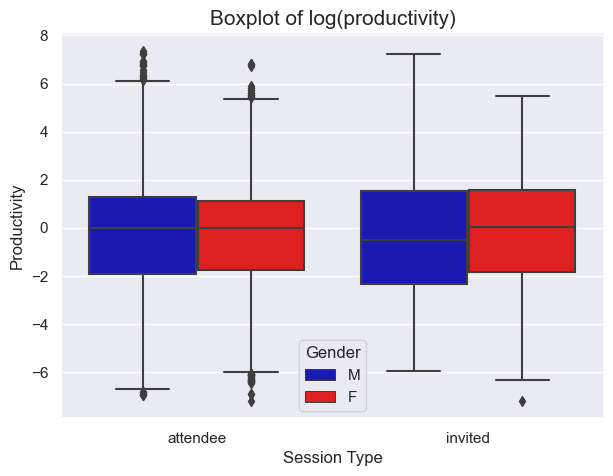

In [85]:
#productivity
sns.boxplot(data=researchers , x="SessionType", y="log_Productivity", hue='Gender', palette = ['mediumblue', 'red'])
plt.xlabel("Session Type", fontsize=12)
plt.ylabel("Productivity", fontsize=12)
plt.title("Boxplot of log(productivity)", fontsize = 15)
plt.savefig("Figures/logProductivity_boxplot", bbox_inches='tight')
plt.show()

In [48]:
#FDI: Diversity
#FHPP: Philosopy and history of physics

## Permutation test

In [115]:
def permutationTest(df, labelColumn, attributes, iterations):
    results = {}
    groupedData = df.groupby(labelColumn).mean(numeric_only = True)
    for c in attributes:
        delta = groupedData[c]['F'] - groupedData[c]['M'] #difference in sample mean
        permutationDelta = []
        for i in range(0, iterations):
            df['Permutation'] = np.random.permutation(df[labelColumn].values)
            groupedData_permutated = df.groupby('Permutation').mean(numeric_only = True)
            delta_permutation = groupedData_permutated[c]['F'] - groupedData_permutated[c]['M'] #difference of current permutation
            permutationDelta.append(delta_permutation)
        results[c] = {'Delta': delta, 'PermutationDelta': permutationDelta, 'FemaleAvg': groupedData_permutated[c]['F'], 'MaleAvg': groupedData_permutated[c]['M']}
    return results

In [117]:
permutationResults_invited = permutationTest(invited, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)
permutationResults_attendees = permutationTest(attendees, 'Gender', ['Seniority', 'CumulativePaperCount', 'Productivity'], 10000)

In [118]:
permutationResults_invited.keys()

dict_keys(['Seniority', 'CumulativePaperCount', 'Productivity'])

In [88]:
permutations_inv = pd.DataFrame({'Seniority': permutationResults_invited['Seniority']['PermutationDelta'], 'PaperCount': permutationResults_invited['CumulativePaperCount']['PermutationDelta'], 'Productivity': permutationResults_invited['Productivity']['PermutationDelta']} )
permutations_att = pd.DataFrame({'Seniority': permutationResults_attendees['Seniority']['PermutationDelta'], 'PaperCount': permutationResults_attendees['CumulativePaperCount']['PermutationDelta'], 'Productivity': permutationResults_attendees['Productivity']['PermutationDelta']} )

In [104]:
#calculate p-value
#permutations_inv[permutations_inv.Seniority = ]
#permutationResults_invited['Seniority']['Delta']


-1.6547186380455354

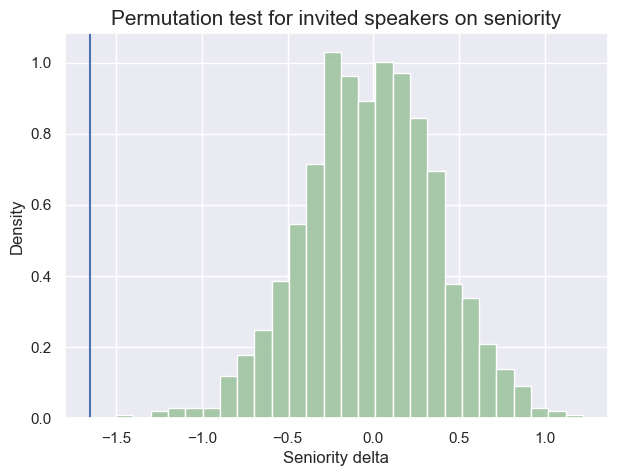

In [105]:
sns.histplot(data = permutations_inv , x = 'Seniority', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['Seniority']['Delta'])
plt.xlabel('Seniority delta', fontsize=12)
plt.title("Permutation test for invited speakers on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniority", bbox_inches='tight')
plt.show()

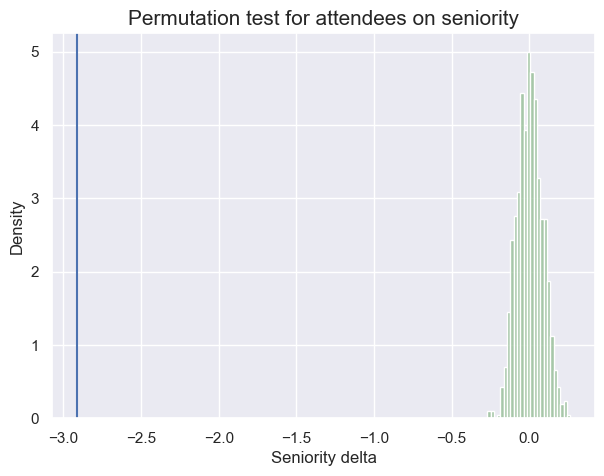

In [106]:
sns.histplot(data = permutations_att , x = 'Seniority', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['Seniority']['Delta']) 
plt.xlabel('Seniority delta', fontsize=12)
plt.title("Permutation test for attendees on seniority", fontsize = 15)
plt.savefig("Figures/permutationtest_seniority_Attendees", bbox_inches='tight')
plt.show()

In [ ]:
sns.histplot(data = permutations_inv , x = 'PaperCount', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['CumulativePaperCount']['Delta']) 
plt.xlabel('Paper count delta', fontsize=12)
plt.title("Permutation test for invited speakers on paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount", bbox_inches='tight')
plt.show()

In [ ]:
sns.histplot(data = permutations_att , x = 'PaperCount', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['CumulativePaperCount']['Delta']) 
plt.xlabel('Paper count delta', fontsize=12)
plt.title("Permutation test for attendees on paper count", fontsize = 15)
plt.savefig("Figures/permutationtest_cumulativePaperCount_Attendees", bbox_inches='tight')
plt.show()

In [ ]:
sns.histplot(data = permutations_inv , x = 'Productivity', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_invited['Productivity']['Delta']) 
plt.xlabel('Productivity delta', fontsize=12)
plt.title("Permutation test for invited speakers on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity", bbox_inches='tight')
plt.show()

In [ ]:
sns.histplot(data = permutations_att , x = 'Productivity', stat = 'density', color = 'darkseagreen')
plt.axvline(x=permutationResults_attendees['Productivity']['Delta']) 
plt.xlabel('Productivity delta', fontsize=12)
plt.title("Permutation test for attendees on productivity", fontsize = 15)
plt.savefig("Figures/permutationtest_productivity_Attendees", bbox_inches='tight')
plt.show()

In [ ]:
#calculate p-values now.
#How many is at empirical mean or more extreme

In [91]:
df = researchers
groupedData = df.groupby('Gender').mean(numeric_only = True)
seniority_empiricalDelta = groupedData['Seniority']['F'] - groupedData['Seniority']['M']
paperCount_empiricalDelta = groupedData['CumulativePaperCount']['F'] - groupedData['CumulativePaperCount']['M']
Productivity_empiricalDelta = groupedData['Productivity']['F'] - groupedData['Productivity']['M']

In [94]:
Productivity_empiricalDelta

-0.19307097168916254

In [65]:
researchers['PermutatedGender'] = np.random.permutation(researchers.Gender.values)
researchers
#SessionType - insteaf of avg. count number of invited
#Seniority, CumulativePaperCount, Productivity

,ID,OriginalName,API_Name,AuthorCount,MaxPaperCount,Field,FirstPaperYear,Year,Name,Institution,...,FirstName,Seniority,CumulativePaperCount,Productivity,Gender,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PermutatedGender
0,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2010,K. Kempa,Boston College,...,K.,23,59,2.565217,M,6.228819,5.882643,1.359081,0.000000,M
1,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2017,K. Kempa,Boston College,...,K.,30,69,2.300000,M,6.228819,6.108524,1.201634,0.000000,M
2,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2006,K. Kempa,Boston College,...,K.,19,49,2.578947,M,6.228819,5.614710,1.366782,0.000000,M
3,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2014,K. Kempa,Boston College,...,K.,27,64,2.370370,M,6.228819,6.000000,1.245112,0.000000,M
4,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2009,K. Kempa,Boston College and Solasta Inc.,...,K.,22,55,2.500000,M,6.228819,5.781360,1.321928,0.000000,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50879,35643,Nour Nijem,Nour Nijem,2,46,Physics,2008,2011,Nour Nijem,Univeristy of Texas at Dallas,...,Nour,3,7,2.333333,F,5.523562,2.807355,1.222392,1.000000,M
50880,35854,Jason Williams,J. Williams,206,40,Medicine,2005,2010,J. Williams,University of Western Australia,...,J.,5,36,7.200000,M,5.321928,5.169925,2.847997,7.686501,M
50881,35854,Jason Williams,J. Williams,206,40,Medicine,2005,2008,J. Williams,U. Western Australia,...,J.,3,26,8.666667,M,5.321928,4.700440,3.115477,7.686501,M
50882,35880,Slava Dobrovitski,Slava Dobrovitski,1,2,Physics,2018,2022,Slava Dobrovitski,Delft University of Technology,...,Slava,4,1,0.250000,M,1.000000,0.000000,-2.000000,0.000000,M


In [57]:
researchers

,ID,OriginalName,API_Name,AuthorCount,MaxPaperCount,Field,FirstPaperYear,Year,Name,Institution,...,FirstName,Seniority,CumulativePaperCount,Productivity,Gender,log_MaxPaperCount,log_CumulativePaperCount,log_Productivity,log_AuthorCount,PermutatedGender
0,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2010,K. Kempa,Boston College,...,K.,23,59,2.565217,M,6.228819,5.882643,1.359081,0.000000,M
1,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2017,K. Kempa,Boston College,...,K.,30,69,2.300000,M,6.228819,6.108524,1.201634,0.000000,M
2,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2006,K. Kempa,Boston College,...,K.,19,49,2.578947,M,6.228819,5.614710,1.366782,0.000000,M
3,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2014,K. Kempa,Boston College,...,K.,27,64,2.370370,M,6.228819,6.000000,1.245112,0.000000,F
4,155007,Kris Kempa,K. Kempa,1,75,Physics,1987,2009,K. Kempa,Boston College and Solasta Inc.,...,K.,22,55,2.500000,M,6.228819,5.781360,1.321928,0.000000,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50879,35643,Nour Nijem,Nour Nijem,2,46,Physics,2008,2011,Nour Nijem,Univeristy of Texas at Dallas,...,Nour,3,7,2.333333,F,5.523562,2.807355,1.222392,1.000000,M
50880,35854,Jason Williams,J. Williams,206,40,Medicine,2005,2010,J. Williams,University of Western Australia,...,J.,5,36,7.200000,M,5.321928,5.169925,2.847997,7.686501,M
50881,35854,Jason Williams,J. Williams,206,40,Medicine,2005,2008,J. Williams,U. Western Australia,...,J.,3,26,8.666667,M,5.321928,4.700440,3.115477,7.686501,M
50882,35880,Slava Dobrovitski,Slava Dobrovitski,1,2,Physics,2018,2022,Slava Dobrovitski,Delft University of Technology,...,Slava,4,1,0.250000,M,1.000000,0.000000,-2.000000,0.000000,M
